# Models 

This notebook contains the examples of attempted models and approaches employed towards finding solution to the ACMG classification problem. This particular version is concerned with custom parsing - related notebook EDA - Custom Parsing

## Imports

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, f1_score, recall_score, cohen_kappa_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import dalex as dx
from utils.EDA_utils import *
from utils.utils import get_dataset
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

In [16]:
df = get_dataset("data/", samples=["EE_015", "EE_050", "EE_069"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)

In [17]:
df.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_fragment,FILTER_haplotype,FILTER_map_qual,FILTER_base_qual,FILTER_weak_evidence,...,SpliceAI_pred_SYMBOL,LOEUF,NMD,PHENOTYPES_exist,FLAGS_start,PUBMED_exist,SIFT_class,SIFT_pred,PolyPhen_class,PolyPhen_pred
0,chr1,15820,G,T,.,0,0,0,0,0,...,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
1,chr1,17385,G,A,.,0,0,0,0,0,...,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
2,chr1,17697,G,C,.,0,0,0,0,0,...,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
3,chr1,133129,G,A,.,0,0,0,0,0,...,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
4,chr1,183629,G,A,.,0,0,0,0,0,...,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN


In [18]:
custom_mapping = {
    'Benign': 0,
    'Likely%40Benign': 1,
    'Uncertain%40Significance': 2,
    'Likely%40Pathogenic': 3,
    'Pathogenic': 4
}

target_column = "ACMG_class"


df = df.loc[:, ~df.columns.duplicated()]
preprocessed_df1 = preprocess(df)
preprocessed_df2 = preprocess(df, fill_median=True)
preprocessed_df3 = preprocess(df, one_hot_nans = False)

encoded_df1, encoders1, target_mapping1 = encode(preprocessed_df1, target_column, custom_mapping)
encoded_df2, encoders2, target_mapping2 = encode(preprocessed_df2, target_column, custom_mapping)
encoded_df3, encoders3, target_mapping3 = encode(preprocessed_df3, target_column, custom_mapping)

In [19]:
encoded_df1.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_fragment,FILTER_haplotype,FILTER_map_qual,FILTER_base_qual,FILTER_weak_evidence,...,SpliceAI_pred_DS_AL_is_nan,SpliceAI_pred_DS_DG_is_nan,SpliceAI_pred_DS_DL_is_nan,SpliceAI_pred_SYMBOL_is_nan,LOEUF_is_nan,NMD_is_nan,SIFT_class_is_nan,SIFT_pred_is_nan,PolyPhen_class_is_nan,PolyPhen_pred_is_nan
0,0,15820,1773,2117,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,17385,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,17697,1773,721,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,133129,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,183629,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [20]:
encoded_df2.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_fragment,FILTER_haplotype,FILTER_map_qual,FILTER_base_qual,FILTER_weak_evidence,...,SpliceAI_pred_DS_AL_is_nan,SpliceAI_pred_DS_DG_is_nan,SpliceAI_pred_DS_DL_is_nan,SpliceAI_pred_SYMBOL_is_nan,LOEUF_is_nan,NMD_is_nan,SIFT_class_is_nan,SIFT_pred_is_nan,PolyPhen_class_is_nan,PolyPhen_pred_is_nan
0,0,15820,1773,2117,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,17385,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,17697,1773,721,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,133129,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,183629,1773,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [21]:
encoded_df3.head()

,#CHROM,POS,REF,ALT,QUAL,FILTER_fragment,FILTER_haplotype,FILTER_map_qual,FILTER_base_qual,FILTER_weak_evidence,...,SpliceAI_pred_SYMBOL,LOEUF,NMD,PHENOTYPES_exist,FLAGS_start,PUBMED_exist,SIFT_class,SIFT_pred,PolyPhen_class,PolyPhen_pred
0,0,15820,1773,2117,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0
1,0,17385,1773,0,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0
2,0,17697,1773,721,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0
3,0,133129,1773,0,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0
4,0,183629,1773,0,0,0,0,0,0,0,...,8747,-0.97,1,0,0,0,0,-1.0,0,-1.0


## Model Training

In [22]:
def invert_dict(original_dict):
    inverted_dict = {v: k for k, v in original_dict.items()}
    return inverted_dict

In [23]:
inverted_mapping = invert_dict(target_mapping1)

Example model training

In [24]:
X = encoded_df1.drop(columns=['ACMG_class'])
y = encoded_df1['ACMG_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
clf = RandomForestClassifier(class_weight=dict(enumerate(class_weights)))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(y_pred)

report = classification_report(y_test, y_pred)
print(report)

[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     76922
           1       0.75      0.63      0.68      5151
           2       0.84      0.61      0.70      6781
           3       0.75      0.12      0.21        25
           4       1.00      0.10      0.18        10

    accuracy                           0.94     88889
   macro avg       0.86      0.49      0.55     88889
weighted avg       0.94      0.94      0.94     88889



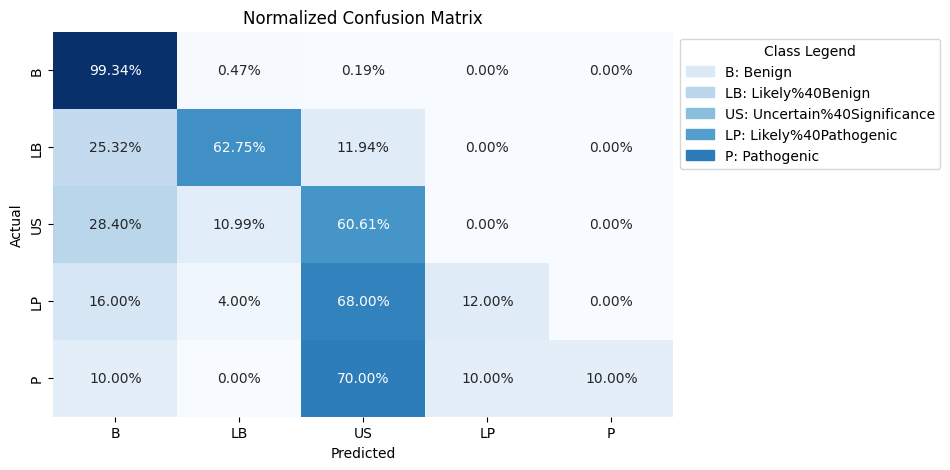

In [25]:
get_confusion_matrix_plot(y_test, y_pred, inverted_mapping)

### Pipeline for Trying multiple different models in sklearn

This pipeline compares the performance of different models implemented in sklearn: Random Forrest, AdaBoost, Decision Tree, Logistic Regression, Bagging.
The results are shown in the form of a confusion matrix. The most promissing model appears to be AdaBoost.
Good performance on majority class is often balanced by bad performance minority class and vice-verse, as such ensamble models might be a good idea.

## Regression Models

In [26]:
# Define datasets and preprocessings
preprocessings = [
    ("None", None),
    ("MinMax", MinMaxScaler()),
    ("Robust", RobustScaler())
]

datasets = [
    ("Encoded - OneHot Nans, Outside Range", encoded_df1),
    ("Encoded - OneHot Nans, Median",encoded_df2),
    ("Encoded - Outside Range", encoded_df3)
]

# Results dictionary
results_dict = {}

progress = 0
for preprocessing_name, preprocessing_method in preprocessings:
    print(f"General Progress: {progress}/{len(preprocessings)}")
    progress+=1
    for dataset_name, dataset in tqdm(datasets, desc="Datasets Progress"):
        X = dataset.drop(columns=['ACMG_class'])
        y = dataset['ACMG_class']

        if preprocessing_name != "None":
            X = pd.DataFrame(preprocessing_method.fit_transform(X), columns=X.columns)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        model_seed = 42

        class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

        models = [
            ('Random Forest', RandomForestRegressor(random_state=model_seed)),
            ('AdaBoost', AdaBoostRegressor(random_state=model_seed)),
            ('Bagging', BaggingRegressor(random_state=model_seed)),
            ('Decision Tree', DecisionTreeRegressor(random_state=model_seed)),
            ('Linear Regression', LinearRegression()),
            ('KNN Regressor', KNeighborsRegressor(n_neighbors=5))
        ]

        for model_name, model in models:
            reg = model

            pipeline = Pipeline([
                ('regressor', reg)
            ])

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            
            # Save results to dictionary
            result_key = f"{model_name} - {dataset_name} - {preprocessing_name}"
            results_dict[result_key] = {
                'model': model_name,
                'dataset': dataset_name,
                'preprocessing': preprocessing_name,
                'mae': mae,
                'mse': mse
            }

# Find the model with the smallest MAE
min_mae_result = min(results_dict.items(), key=lambda x: x[1]['mae'])
print(f"\nModel with the smallest MAE:")
print(f"Model: {min_mae_result[1]['model']}")
print(f"Dataset: {min_mae_result[1]['dataset']}")
print(f"Preprocessing: {min_mae_result[1]['preprocessing']}")
print(f"MAE: {min_mae_result[1]['mae']}")

min_mse_result = min(results_dict.items(), key=lambda x: x[1]['mse'])
print(f"\nModel with the smallest MSE:")
print(f"Model: {min_mse_result[1]['model']}")
print(f"Dataset: {min_mse_result[1]['dataset']}")
print(f"Preprocessing: {min_mse_result[1]['preprocessing']}")
print(f"MSE: {min_mse_result[1]['mse']}")

General Progress: 0/3


Datasets Progress:   0%|          | 0/3 [09:37<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Define datasets and preprocessings
preprocessings = [
    ("None", None),
    ("MinMax", MinMaxScaler()),
    ("Robust", RobustScaler())
]

datasets = [
    ("Encoded - OneHot Nans, Outside Range", encoded_df1),
    ("Encoded - OneHot Nans, Median", encoded_df2),
    ("Encoded - Outside Range", encoded_df3)
]

# Results dictionary
results_dict = {}

progress = 0
for preprocessing_name, preprocessing_method in tqdm(preprocessings, desc="Progress"):
    print(f"General Progress: {progress}/{len(preprocessings)}")
    progress+=1
    for dataset_name, dataset in tqdm(datasets, desc="Datasets Progress"):
        X = dataset.drop(columns=['ACMG_class'])
        y = dataset['ACMG_class']

        if preprocessing_name != "None":
            X = pd.DataFrame(preprocessing_method.fit_transform(X), columns=X.columns)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        model_seed = 42

        # Compute sample weights based on class weights
        sample_weights = compute_sample_weight('balanced', y_train)

        models = [
            ('Random Forest', RandomForestRegressor(random_state=model_seed)),
            ('AdaBoost', AdaBoostRegressor(random_state=model_seed)),
            ('Bagging', BaggingRegressor(random_state=model_seed)),
            ('Decision Tree', DecisionTreeRegressor(random_state=model_seed)),
            ('Linear Regression', LinearRegression())
        ]

        for model_name, model in models:
            reg = model

            pipeline = Pipeline([
                ('regressor', reg)
            ])

            # Train the model with sample weights
            pipeline.fit(X_train, y_train, regressor__sample_weight=sample_weights)
            
            # Make predictions
            y_pred = pipeline.predict(X_test)
            
            # Evaluate with mean absolute error
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)

            # Save results to dictionary
            result_key = f"{model_name} - {dataset_name} - {preprocessing_name}"
            results_dict[result_key] = {
                'model': model_name,
                'dataset': dataset_name,
                'preprocessing': preprocessing_name,
                'mae': mae,
                'mse' : mse
            }

# Find the model with the smallest MAE
min_mae_result = min(results_dict.items(), key=lambda x: x[1]['mae'])
print(f"\nModel with the smallest MAE weighted:")
print(f"Model: {min_mae_result[1]['model']}")
print(f"Dataset: {min_mae_result[1]['dataset']}")
print(f"Preprocessing: {min_mae_result[1]['preprocessing']}")
print(f"MAE: {min_mae_result[1]['mae']}")

min_mse_result = min(results_dict.items(), key=lambda x: x[1]['mse'])
print(f"\nModel with the smallest MSE weighted:")
print(f"Model: {min_mse_result[1]['model']}")
print(f"Dataset: {min_mse_result[1]['dataset']}")
print(f"Preprocessing: {min_mse_result[1]['preprocessing']}")
print(f"MSE: {min_mse_result[1]['mse']}")

Progress:   0%|          | 0/3 [00:00<?, ?it/s]

General Progress: 0/3


Progress:  33%|███▎      | 1/3 [2:10:17<4:20:35, 7817.78s/it]

General Progress: 1/3


Progress:  67%|██████▋   | 2/3 [4:18:14<2:08:54, 7734.96s/it]

General Progress: 2/3


Progress: 100%|██████████| 3/3 [6:28:08<00:00, 7762.91s/it]  


Model with the smallest MAE weighted:
Model: Decision Tree
Dataset: Encoded - OneHot Nans, Outside Range
Preprocessing: None
MAE: 0.11789985262518422

Model with the smallest MSE weighted:
Model: Random Forest
Dataset: Encoded - OneHot Nans, Median
Preprocessing: MinMax
MSE: 0.08617731665335417


## More Stats

In [ ]:
preprocessings = [
    ("None", None),
    ("MinMax", MinMaxScaler()),
    ("Robust", RobustScaler())
]

datasets = [
    ("Encoded - OneHot Nans, Outside Range", encoded_df1),
    ("Encoded - OneHot Nans, Median", encoded_df2),
    ("Encoded - Outside Range", encoded_df3)
]

results_dict = {}
for preprocessing_name, preprocessing_method in preprocessings:
    for dataset_name, dataset in datasets:
        X = dataset.drop(columns=['ACMG_class'])
        y = dataset['ACMG_class']

        if preprocessing_name != "None":
            X = pd.DataFrame(preprocessing_method.fit_transform(X), columns=X.columns)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        model_seed = 42

        class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

        models = [
            ('CatBoost', CatBoostClassifier(class_weights=class_weights, verbose=False, random_state=model_seed)),
            ('XGBoost', XGBClassifier(scale_pos_weight=sum(y_train==0)/sum(y_train==1), random_state=model_seed)),
            ('LightGBM', LGBMClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('Random Forest', RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('AdaBoost', AdaBoostClassifier(random_state=model_seed)),
            ('Bagging', BaggingClassifier(random_state=model_seed)),
            ('Decision Tree', DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight=dict(enumerate(class_weights)), random_state=model_seed)),
            ('KNN Classifier', KNeighborsClassifier(n_neighbors=5))
        ]

        for model_name, model in models:
            clf = model

            pipeline = Pipeline([
                ('classifier', clf)
            ])

            if model_name == 'AdaBoost':
                sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
                pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
            else:
                pipeline.fit(X_train, y_train)

            y_pred = pipeline.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            f1_weighted = f1_score(y_test, y_pred, average='weighted')
            macro_recall = recall_score(y_test, y_pred, average='macro')
            gmean = np.sqrt(f1_weighted * macro_recall)
            kappa = cohen_kappa_score(y_test, y_pred)

            # Save results to dictionary
            result_key = f"{model_name} - {dataset_name} - {preprocessing_name}"
            results_dict[result_key] = {
                'model': model_name,
                'dataset': dataset_name,
                'preprocessing': preprocessing_name,
                'mae': mae,
                'mse': mse,
                'f1_weighted': f1_weighted,
                'macro_recall': macro_recall,
                'gmean': gmean,
                'kappa': kappa
            }

min_mae_result = min(results_dict.items(), key=lambda x: x[1]['mae'])
print(f"\nModel with the smallest MAE:")
print(f"Model: {min_mae_result[1]['model']}")
print(f"Dataset: {min_mae_result[1]['dataset']}")
print(f"Preprocessing: {min_mae_result[1]['preprocessing']}")
print(f"MAE: {min_mae_result[1]['mae']}")

min_mse_result = min(results_dict.items(), key=lambda x: x[1]['mse'])
print(f"\nModel with the smallest MSE:")
print(f"Model: {min_mse_result[1]['model']}")
print(f"Dataset: {min_mse_result[1]['dataset']}")
print(f"Preprocessing: {min_mse_result[1]['preprocessing']}")
print(f"MSE: {min_mse_result[1]['mse']}")

maxf1_result = max(results_dict.items(), key=lambda x: x[1]['f1_weighted'])
print(f"\nModel with the biggest F1 weghted:")
print(f"Model: {maxf1_result[1]['model']}")
print(f"Dataset: {maxf1_result[1]['dataset']}")
print(f"Preprocessing: {maxf1_result[1]['preprocessing']}")
print(f"f1_weighted: {maxf1_result[1]['f1_weighted']}")

max_macro_recall_result = max(results_dict.items(), key=lambda x: x[1]['macro_recall'])
print(f"\nModel with the biggest macro_recall:")
print(f"Model: {max_macro_recall_result[1]['model']}")
print(f"Dataset: {max_macro_recall_result[1]['dataset']}")
print(f"Preprocessing: {max_macro_recall_result[1]['preprocessing']}")
print(f"macro_recall: {max_macro_recall_result[1]['macro_recall']}")

max_gmean_result = max(results_dict.items(), key=lambda x: x[1]['gmean'])
print(f"\nModel with the biggest gmean:")
print(f"Model: {max_gmean_result[1]['model']}")
print(f"Dataset: {max_gmean_result[1]['dataset']}")
print(f"Preprocessing: {max_gmean_result[1]['preprocessing']}")
print(f"gmean: {max_gmean_result[1]['gmean']}")

max_kappa_result = max(results_dict.items(), key=lambda x: x[1]['kappa'])
print(f"\nModel with the biggest kappa:")
print(f"Model: {max_kappa_result[1]['model']}")
print(f"Dataset: {max_kappa_result[1]['dataset']}")
print(f"Preprocessing: {max_kappa_result[1]['preprocessing']}")
print(f"kappa: {max_kappa_result[1]['kappa']}")

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [06:25:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9304
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 159
[LightGBM] [Info] Start training from score -1.630245
[LightGBM] [Info] Start training from score -1.629008
[LightGBM] [Info] Start training from score -1.621538
[LightGBM] [Info] Start training from score -1.563183
[LightGBM] [Info] Start training from score -1.604791


d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [06:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9264
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 158
[LightGBM] [Info] Start training from score -1.630245
[LightGBM] [Info] Start training from score -1.629008
[LightGBM] [Info] Start training from score -1.621538
[LightGBM] [Info] Start training from score -1.563183
[LightGBM] [Info] Start training from score -1.604791


d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [06:59:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9200
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 107
[LightGBM] [Info] Start training from score -1.630245
[LightGBM] [Info] Start training from score -1.629008
[LightGBM] [Info] Start training from score -1.621538
[LightGBM] [Info] Start training from score -1.563183
[LightGBM] [Info] Start training from score -1.604791


d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [07:15:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9295
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 159
[LightGBM] [Info] Start training from score -1.630245
[LightGBM] [Info] Start training from score -1.629008
[LightGBM] [Info] Start training from score -1.621538
[LightGBM] [Info] Start training from score -1.563183
[LightGBM] [Info] Start training from score -1.604791


d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [07:32:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9261
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 158
[LightGBM] [Info] Start training from score -1.630245
[LightGBM] [Info] Start training from score -1.629008
[LightGBM] [Info] Start training from score -1.621538
[LightGBM] [Info] Start training from score -1.563183
[LightGBM] [Info] Start training from score -1.604791


d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [07:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9191
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 107
[LightGBM] [Info] Start training from score -1.630245
[LightGBM] [Info] Start training from score -1.629008
[LightGBM] [Info] Start training from score -1.621538
[LightGBM] [Info] Start training from score -1.563183
[LightGBM] [Info] Start training from score -1.604791


d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [08:04:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9449
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 159
[LightGBM] [Info] Start training from score -1.630245
[LightGBM] [Info] Start training from score -1.629008
[LightGBM] [Info] Start training from score -1.621538
[LightGBM] [Info] Start training from score -1.563183
[LightGBM] [Info] Start training from score -1.604791


d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [08:22:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9439
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 158
[LightGBM] [Info] Start training from score -1.630245
[LightGBM] [Info] Start training from score -1.629008
[LightGBM] [Info] Start training from score -1.621538
[LightGBM] [Info] Start training from score -1.563183
[LightGBM] [Info] Start training from score -1.604791


d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [08:40:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9345
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 107
[LightGBM] [Info] Start training from score -1.630245
[LightGBM] [Info] Start training from score -1.629008
[LightGBM] [Info] Start training from score -1.621538
[LightGBM] [Info] Start training from score -1.563183
[LightGBM] [Info] Start training from score -1.604791


d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model with the smallest MAE:
Model: XGBoost
Dataset: Encoded - OneHot Nans, Outside Range
Preprocessing: MinMax
MAE: 0.0751949060063675

Model with the smallest MSE:
Model: XGBoost
Dataset: Encoded - OneHot Nans, Outside Range
Preprocessing: MinMax
MSE: 0.11749485313143358

Model with the biggest F1 weghted:
Model: XGBoost
Dataset: Encoded - OneHot Nans, Median
Preprocessing: MinMax
f1_weighted: 0.9433953668194193

Model with the biggest macro_recall:
Model: LightGBM
Dataset: Encoded - OneHot Nans, Outside Range
Preprocessing: MinMax
macro_recall: 0.7384313056578302

Model with the biggest gmean:
Model: LightGBM
Dataset: Encoded - OneHot Nans, Outside Range
Preprocessing: MinMax
gmean: 0.819169156300544

Model with the biggest kappa:
Model: XGBoost
Dataset: Encoded - OneHot Nans, Median
Preprocessing: MinMax
kappa: 0.7571587647208945


### Training Best Performing models from Above Section

In [ ]:
def apply_threshold(y_pred, a1, a2, a3, a4):
    assert a1<a2<a3<a4
    result = []
    for val in y_pred:
        if val<a1:
            result.append(0)
        elif val>=a1 and val<a2:
            result.append(1)
        elif val>=a2 and val<a3:
            result.append(2)
        elif val>=a3 and val<a4:
            result.append(3)
        elif val>=a4:
            result.append(4)
    return np.array(result)

#### Unwieghted Smallest MAE

In [ ]:
model_seed = 42
model = DecisionTreeRegressor(random_state=model_seed)
dataset = encoded_df3
X = dataset.drop(columns=['ACMG_class'])
y = dataset['ACMG_class']
preprocessing_method = MinMaxScaler()
X = pd.DataFrame(preprocessing_method.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

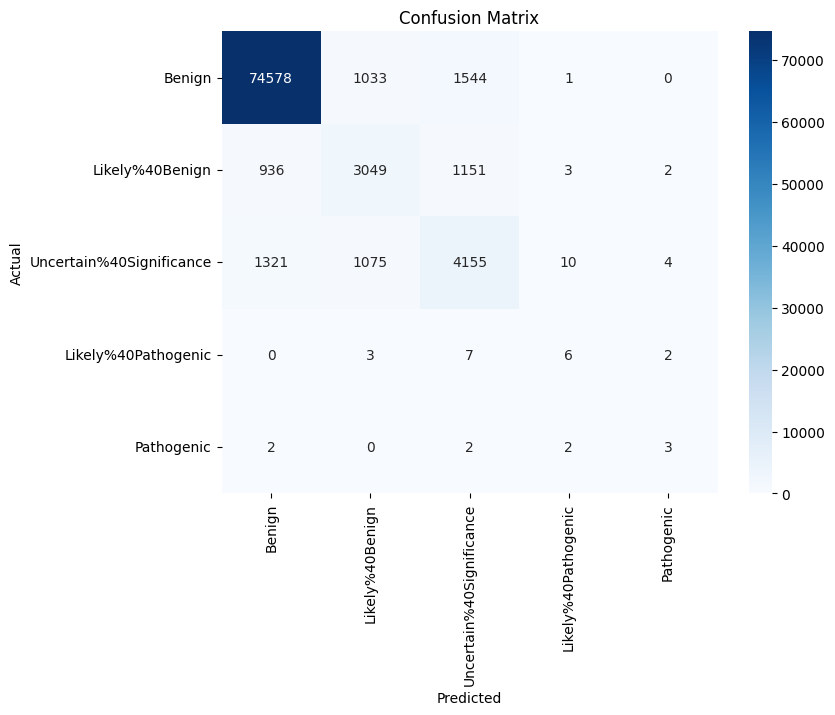

In [ ]:
y_preds = apply_threshold(y_pred, 1, 2, 3, 4)
get_confusion_matrix_plot(y_test, y_preds, inverted_mapping)

#### Unwieghted Smallest MSE

In [ ]:
model_seed = 42
model = RandomForestRegressor(random_state=model_seed)
dataset = encoded_df2
X = dataset.drop(columns=['ACMG_class'])
y = dataset['ACMG_class']
preprocessing_method = MinMaxScaler()
X = pd.DataFrame(preprocessing_method.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

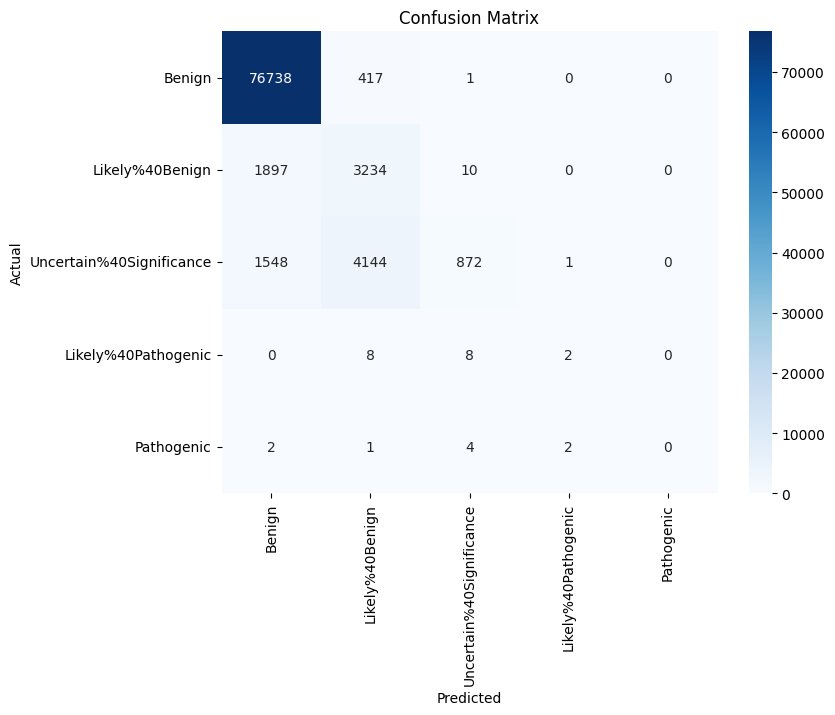

In [ ]:
y_preds = apply_threshold(y_pred, 1, 2, 3, 4)
get_confusion_matrix_plot(y_test, y_preds, inverted_mapping)

#### Weighted Smallest MAE

In [ ]:
model_seed = 42
model = DecisionTreeRegressor(random_state=model_seed)
dataset = encoded_df1
X = dataset.drop(columns=['ACMG_class'])
y = dataset['ACMG_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
sample_weights = compute_sample_weight('balanced', y_train)
model.fit(X_train, y_train, sample_weight = sample_weights)
y_pred = model.predict(X_test)

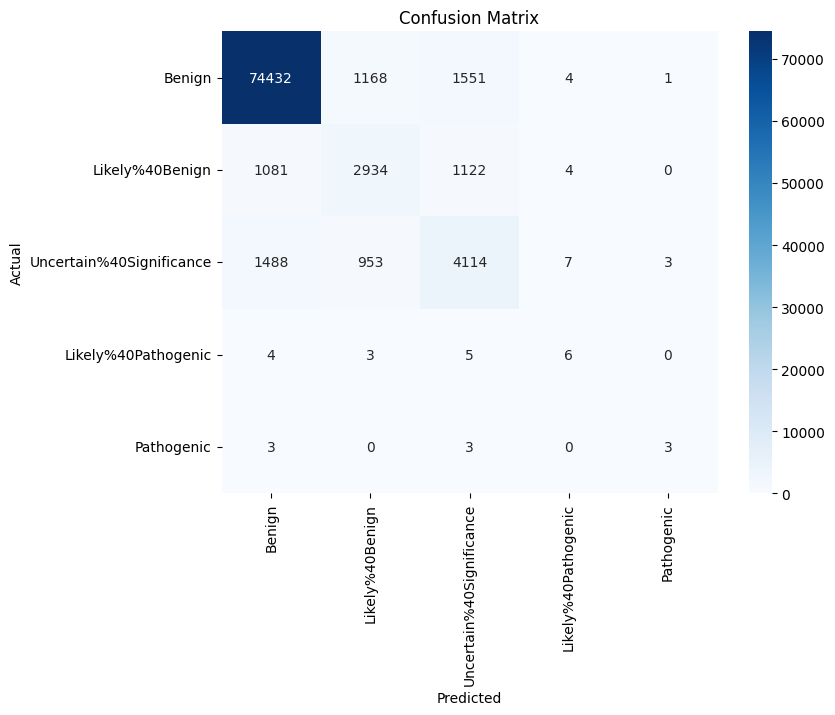

In [ ]:
y_preds = apply_threshold(y_pred, 1, 2, 3, 4)
get_confusion_matrix_plot(y_test, y_preds, inverted_mapping)

#### Weighted Smallest MSE

In [ ]:
model_seed = 42
model = RandomForestRegressor(random_state=model_seed)
dataset = encoded_df2
X = dataset.drop(columns=['ACMG_class'])
y = dataset['ACMG_class']
preprocessing_method = MinMaxScaler()
X = pd.DataFrame(preprocessing_method.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
sample_weights = compute_sample_weight('balanced', y_train)
model.fit(X_train, y_train, sample_weight = sample_weights)
y_pred = model.predict(X_test)

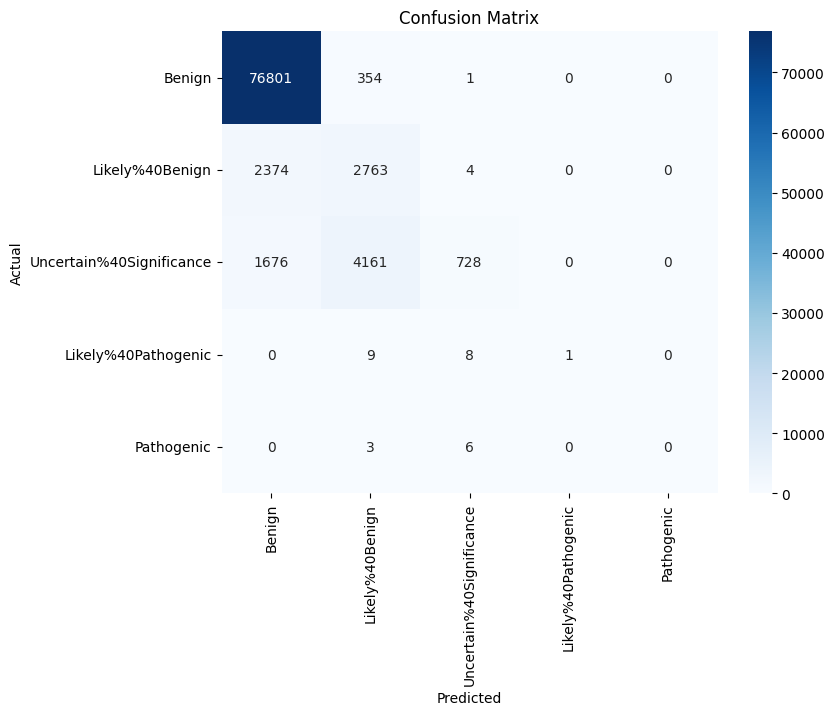

In [ ]:
y_preds = apply_threshold(y_pred, 1, 2, 3, 4)
get_confusion_matrix_plot(y_test, y_preds, inverted_mapping)

#### Best models from classifiers

#### XGBoost 1

In [ ]:
model_seed = 42
model = XGBClassifier(scale_pos_weight=sum(y_train==0)/sum(y_train==1), random_state=model_seed)
dataset = encoded_df1
X = dataset.drop(columns=['ACMG_class'])
y = dataset['ACMG_class']
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
preprocessing_method = MinMaxScaler()
X = pd.DataFrame(preprocessing_method.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
sample_weights = compute_sample_weight('balanced', y_train)
model.fit(X_train, y_train, sample_weight = sample_weights)
y_pred = model.predict(X_test)

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [12:03:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


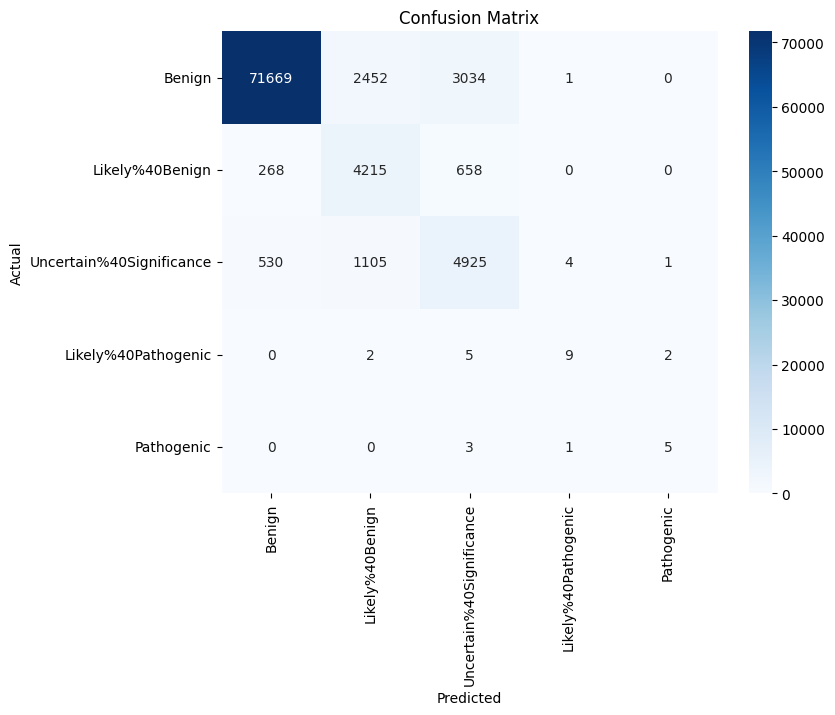

In [ ]:
get_confusion_matrix_plot(y_test, y_pred, inverted_mapping)

#### XGBoost 2

In [ ]:
model_seed = 42
model = XGBClassifier(scale_pos_weight=sum(y_train==0)/sum(y_train==1), random_state=model_seed)
dataset = encoded_df2
X = dataset.drop(columns=['ACMG_class'])
y = dataset['ACMG_class']
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
preprocessing_method = MinMaxScaler()
X = pd.DataFrame(preprocessing_method.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
sample_weights = compute_sample_weight('balanced', y_train)
model.fit(X_train, y_train, sample_weight = sample_weights)
y_pred = model.predict(X_test)

d:\pathogenicity_project\pathogenicity\lib\site-packages\xgboost\core.py:160: UserWarning: [12:03:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


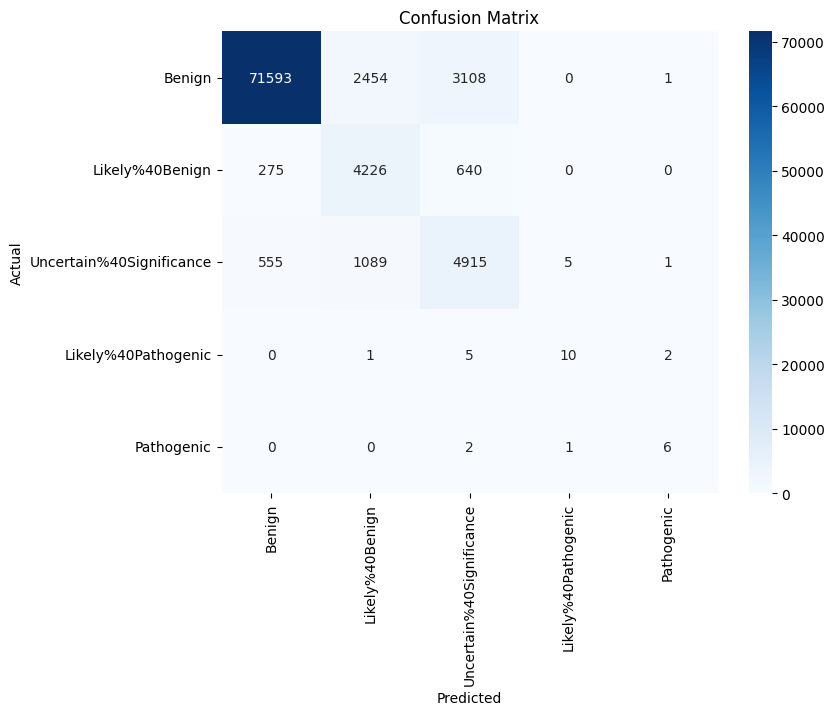

In [ ]:
get_confusion_matrix_plot(y_test, y_pred, inverted_mapping)

#### LightGBM

In [ ]:
model_seed = 42
dataset = encoded_df1
X = dataset.drop(columns=['ACMG_class'])
y = dataset['ACMG_class']
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
model = LGBMClassifier(class_weight=dict(enumerate(class_weights)), random_state=model_seed)
dataset = encoded_df1
preprocessing_method = MinMaxScaler()
X = pd.DataFrame(preprocessing_method.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
sample_weights = compute_sample_weight('balanced', y_train)
model.fit(X_train, y_train, sample_weight = sample_weights)
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9295
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 159
[LightGBM] [Info] Start training from score -9.289257
[LightGBM] [Info] Start training from score -6.585620
[LightGBM] [Info] Start training from score -6.860651
[LightGBM] [Info] Start training from score -1.249556
[LightGBM] [Info] Start training from score -0.341298


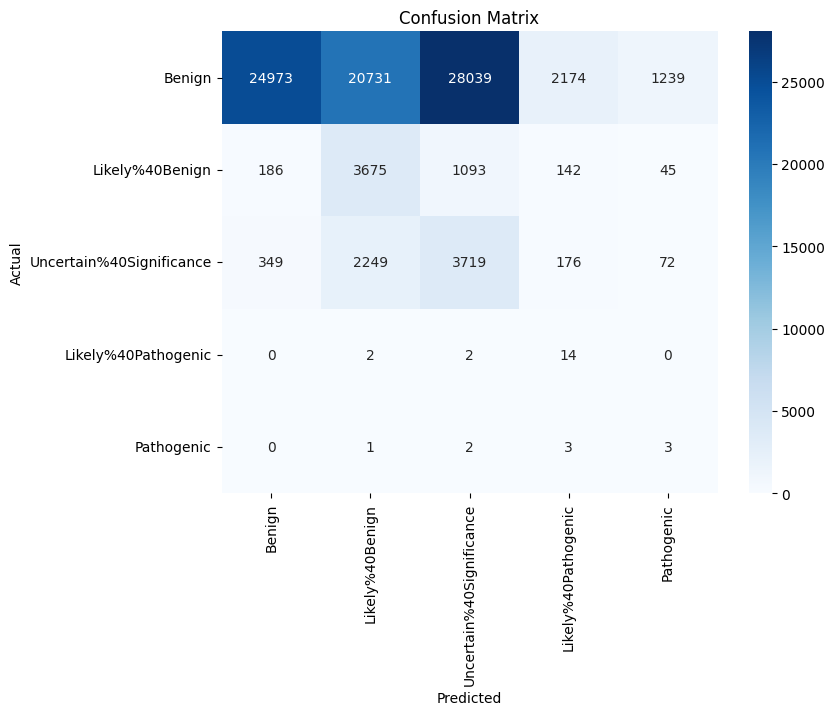

In [ ]:
get_confusion_matrix_plot(y_test, y_pred, inverted_mapping)

### Custom Weight Matrix

In [27]:
inverted_mapping

{0: 'Benign',
 1: 'Likely%40Benign',
 2: 'Uncertain%40Significance',
 3: 'Likely%40Pathogenic',
 4: 'Pathogenic'}

In [52]:
cost_matrix = np.array([
    [0, 1, 3, 5, 6], #B
    [1, 0, 3, 5, 6], #LB
    [5, 3, 0, 1, 2], #US
    [10, 7, 5, 0, 1], #LP
    [12, 10, 5, 1, 0]  #P
], dtype = np.float64)

In [53]:
def custom_loss(y_true, y_pred):
    loss = 0
    for i in range(len(y_true)):
        loss += cost_matrix[y_true[i]][y_pred[i]]
    return loss

In [55]:
class_weights = []
for i in range(5):
    count = dataset["ACMG_class"].value_counts().get(i, 0)
    class_weights.append(count)
class_weights = np.array(class_weights, dtype=np.float64)
class_weights -= np.sum(class_weights)
class_weights *= (-1)
class_weights /= np.max(class_weights)
weighted_cost_matrix = cost_matrix * class_weights[:, np.newaxis]
weighted_cost_matrix

array([[ 0.        ,  0.13464403,  0.4039321 ,  0.67322016,  0.80786419],
       [ 0.94215944,  0.        ,  2.82647831,  4.71079718,  5.65295661],
       [ 4.61906551,  2.77143931,  0.        ,  0.9238131 ,  1.84762621],
       [ 9.99833481,  6.99883437,  4.99916741,  0.        ,  0.99983348],
       [12.        , 10.        ,  5.        ,  1.        ,  0.        ]])